In [27]:
from torchvision import transforms, utils, models
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

file_path = r"C:\Users\mohammad asfraf\OneDrive\Desktop\ISIC_0035657.jpg"
image = Image.open(file_path).convert('RGB')

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

image_tensor = transform(image).unsqueeze(0)

def efficientnet():
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    old_fc = model.classifier.__getitem__(-1)
    new_fc = nn.Linear(in_features=old_fc.in_features, out_features=7, bias=True)
    model.classifier.__setitem__(-1, new_fc)
    return model

def load_finetuned_model(model_path):
    model = efficientnet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

model_path =  "./models/EfficientNet_augmented_transfer_10Epochs.pth"
model = load_finetuned_model(model_path)
model.eval()

target_layer = model.features[-1]  

target_layers = [target_layer]
cam = GradCAM(model=model, target_layers=target_layers)

prediction = model(image_tensor)
_, index = torch.max(prediction,1)

targets = [ClassifierOutputTarget(index)]
grayscale_cam = cam(input_tensor=image_tensor, targets=targets, eigen_smooth=True)

grayscale_cam = grayscale_cam[0, :]

image_tensor_np = image_tensor.squeeze(0).permute(1, 2, 0).numpy()
image_tensor_np = np.clip(image_tensor_np, 0, 1)

visualization = show_cam_on_image(image_tensor_np, grayscale_cam, use_rgb=True)

In [33]:
np.array(image)

array([[[125, 111, 111],
        [129, 114, 119],
        [128, 119, 124],
        ...,
        [163, 148, 153],
        [165, 146, 152],
        [169, 142, 151]],

       [[125, 116, 111],
        [129, 119, 118],
        [134, 122, 122],
        ...,
        [162, 151, 155],
        [164, 147, 153],
        [167, 144, 154]],

       [[133, 119, 118],
        [135, 121, 121],
        [142, 123, 125],
        ...,
        [169, 148, 155],
        [166, 147, 153],
        [172, 145, 154]],

       ...,

       [[178, 152, 161],
        [175, 155, 166],
        [174, 157, 167],
        ...,
        [208, 188, 190],
        [209, 188, 195],
        [207, 190, 196]],

       [[175, 152, 162],
        [174, 154, 163],
        [173, 155, 167],
        ...,
        [208, 187, 192],
        [207, 186, 191],
        [206, 185, 190]],

       [[176, 149, 156],
        [176, 155, 164],
        [179, 158, 167],
        ...,
        [207, 186, 191],
        [206, 185, 190],
        [205, 184, 189]]

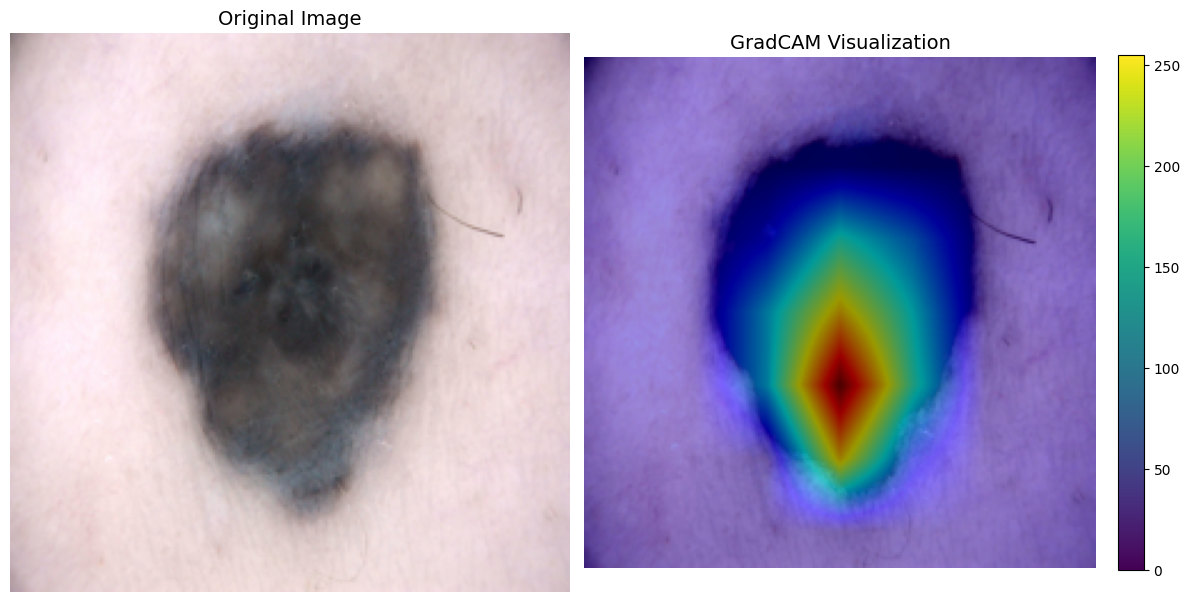

In [28]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image
ax[0].imshow(image.resize((224, 224)))
ax[0].set_title('Original Image', fontsize=14)
ax[0].axis('off')

# Display the GradCAM visualization
heatmap = ax[1].imshow(visualization)
ax[1].set_title('GradCAM Visualization', fontsize=14)
ax[1].axis('off')

# Add a color bar for the heatmap
fig.colorbar(heatmap, ax=ax[1], fraction=0.046, pad=0.04)

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


In [16]:
index

tensor([5])

In [17]:
import cv2
def hair_noise_removal(image):

    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY )

    kernel = cv2.getStructuringElement(1,(9,9))
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    blk= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    _,mask = cv2.threshold(blk,10,255,cv2.THRESH_BINARY)

    result = cv2.inpaint(image,mask,6,cv2.INPAINT_TELEA)

    return result

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 224, 224, 3] to have 3 channels, but got 224 channels instead

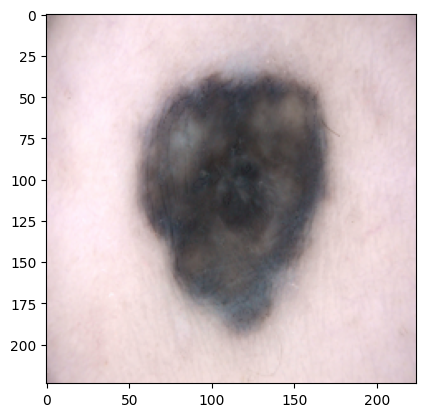

In [18]:
new_image = hair_noise_removal(np.array(image))
plt.imshow(new_image)
image_tensor = torch.tensor(new_image)
image_tensor = image_tensor.unsqueeze(0)
model(image_tensor)